# Visualize attention Map

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

# Define the custom dataset class
class ImageDataset(Dataset):
    def __init__(self, dataset_dir, transform=None):
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(dataset_dir) if f.endswith('.tif')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.dataset_dir, img_name)
        image = Image.open(img_path)
        label = int(img_name.split('_')[-1].split('.')[0])

        if self.transform:
            image = self.transform(image)

        return image, label

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Set the dataset directory
dataset_dir = "/content/gdrive/My Drive/fastai-v3/ALL_IDB2"

# Create the dataset
dataset = ImageDataset(dataset_dir, transform=transform)

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example of iterating through the data loader
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break


torch.Size([32, 3, 224, 224]) torch.Size([32])


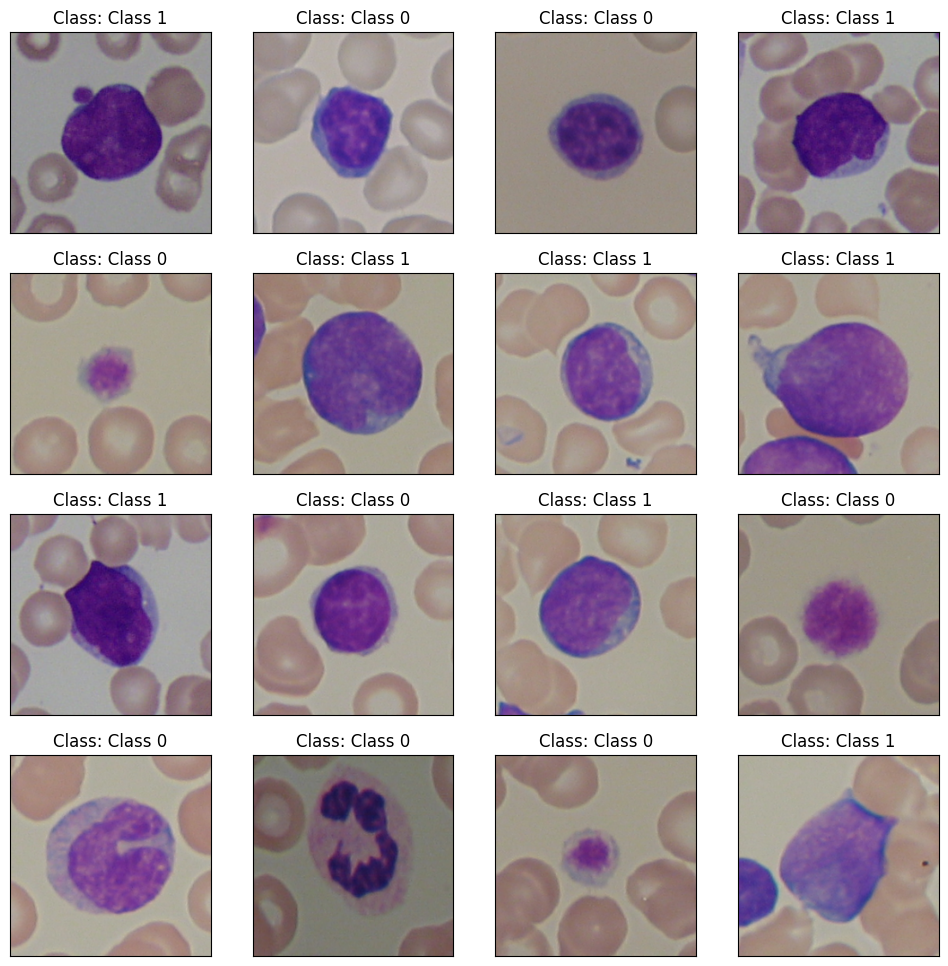

In [3]:
import matplotlib.pyplot as plt

# Function to plot images
def plot_images(images, labels, class_names, n=16):
    plt.figure(figsize=(12, 12))
    for i in range(n):
        plt.subplot(4, 4, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image = images[i].permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
        plt.imshow(image)
        plt.title(f'Class: {class_names[labels[i].item()]}')
    plt.show()

# Define the class names
class_names = ['Class 0', 'Class 1']

# Get a batch of training data
images, labels = next(iter(train_loader))

# Plot the images
plot_images(images, labels, class_names)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms

# Load the pretrained AlexNet model
alexnet = models.alexnet(pretrained=True)

# Freeze all the parameters
for param in alexnet.parameters():
    param.requires_grad = False

# Modify the classifier to fine-tune the last two layers
alexnet.classifier[6] = nn.Linear(alexnet.classifier[6].in_features, 512)
alexnet.classifier.add_module("7", nn.ReLU())
alexnet.classifier.add_module("8", nn.Dropout(0.5))
alexnet.classifier.add_module("9", nn.Linear(512, 2))  # Assuming we have 2 classes

# Unfreeze the last few layers
for param in alexnet.classifier[6:].parameters():
    param.requires_grad = True



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 157MB/s]


Epoch 1/10, Train Loss: 0.7141, Train Acc: 0.6374, Val Loss: 0.5762, Val Acc: 0.5897
Epoch 2/10, Train Loss: 0.4791, Train Acc: 0.7637, Val Loss: 0.3032, Val Acc: 0.8718
Epoch 3/10, Train Loss: 0.3172, Train Acc: 0.8956, Val Loss: 0.2565, Val Acc: 0.8718
Epoch 4/10, Train Loss: 0.2345, Train Acc: 0.9011, Val Loss: 0.2463, Val Acc: 0.8462
Epoch 5/10, Train Loss: 0.2566, Train Acc: 0.9066, Val Loss: 0.2488, Val Acc: 0.8462
Epoch 6/10, Train Loss: 0.2129, Train Acc: 0.9176, Val Loss: 0.2443, Val Acc: 0.8718
Epoch 7/10, Train Loss: 0.2427, Train Acc: 0.8846, Val Loss: 0.3030, Val Acc: 0.8718
Epoch 8/10, Train Loss: 0.2104, Train Acc: 0.9286, Val Loss: 0.2527, Val Acc: 0.8974
Epoch 9/10, Train Loss: 0.2610, Train Acc: 0.9011, Val Loss: 0.2894, Val Acc: 0.8205
Epoch 10/10, Train Loss: 0.2633, Train Acc: 0.8846, Val Loss: 0.3139, Val Acc: 0.8974


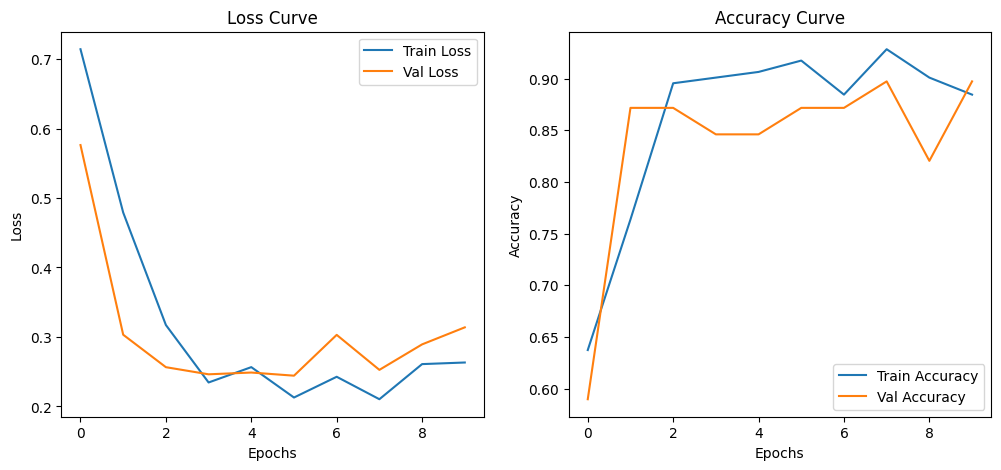

In [5]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.classifier.parameters(), lr=0.001)

# Training and validation function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels.data)

        train_loss /= len(train_loader.dataset)
        train_acc = correct_train.double() / len(train_loader.dataset)
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc.item())

        model.eval()
        val_loss = 0.0
        correct_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = correct_val.double() / len(val_loader.dataset)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc.item())

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Train the model
num_epochs = 10
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    alexnet, train_loader, val_loader, criterion, optimizer, num_epochs)

# Plot the loss and accuracy curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()


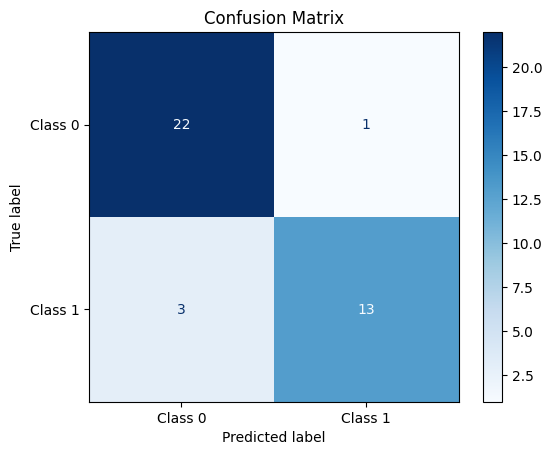

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Test data loader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Function to get predictions and true labels
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions and true labels
preds, labels = get_predictions(alexnet, test_loader)
# Compute the confusion matrix
cm = confusion_matrix(labels, preds)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


# GradCam

In [17]:
import math
from matplotlib import cm
import copy
from torch.nn import ReLU
from torch.autograd import Variable
import torch.nn as nn

def process_img(img, model):
  transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
  ])
  im = transform(img)
  im = im.unsqueeze(0)
  output = model(im)
  _, pred_cls = output.max(dim=1, keepdim=True)
  im = Variable(im, requires_grad=True)
  return im, pred_cls


def format_np_output(np_arr):
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr

def save_image(im):
  im = format_np_output(im)
  im = Image.fromarray(im)
  return im


def apply_colormap_on_image(org_im, activation, colormap_name):
    color_map = cm.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)

    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    shapes = (np.array(org_im).shape[1], np.array(org_im).shape[0])
    heatmap_on_image = heatmap.resize(shapes, Image.ANTIALIAS)
    heatmap_on_image =  Image.blend(org_im.convert("RGBA"), heatmap_on_image, 0.5)
    return no_trans_heatmap, heatmap_on_image

def save_class_activation_images(org_img, activation_map):
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    activation_map = save_image(activation_map )
    return heatmap, heatmap_on_image, activation_map



class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x


class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        target = conv_output.data.numpy()[0]
        weights = np.mean(guided_gradients, axis=(1, 2))
        cam = np.ones(target.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
        return cam


In [19]:

pret_mod = alexnet
# Define the path to the image
image_path = "/content/gdrive/My Drive/fastai-v3/ALL_IDB2/Im119_1.tif"

# Load the image
img = Image.open(image_path)

grad_cam = GradCam(pret_mod, target_layer=11)
im, pred_cls = process_img(img, pret_mod)
cam = grad_cam.generate_cam(im, pred_cls)

heatmap, heatmap_on_image, activation_map = save_class_activation_images(img, cam)



<ipython-input-17-e41b20eb5b0a>:123: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  input_image.shape[3]), Image.ANTIALIAS))/255
<ipython-input-17-e41b20eb5b0a>:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap(colormap_name)
<ipython-input-17-e41b20eb5b0a>:48: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  heatmap_on_image = heatmap.resize(shapes, Image.ANTIALIAS)


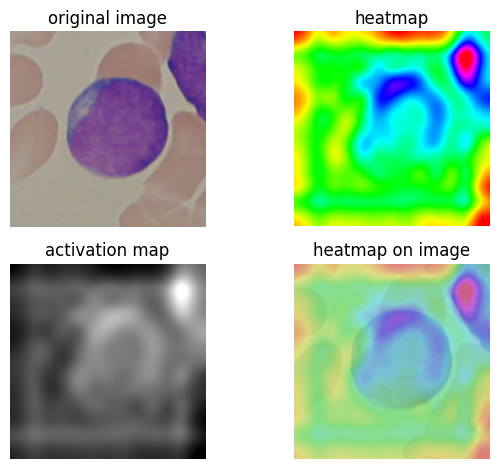

In [20]:
def download_images(images, captions, cols = 2, rows = 2):
    n_img = len(images)
    figure, axis = plt.subplots(rows, cols)
    ax = axis.flatten()
    for i in range(n_img):
      ax[i].imshow(images[i])
      ax[i].axis('off')
      if captions is not None:
        ax[i].set_title(str(captions[i]))
    plt.tight_layout()


images = [img, heatmap,  activation_map, heatmap_on_image]
captions = ['original image', 'heatmap', 'activation map', 'heatmap on image']
fig = download_images(images, captions, cols = 2, rows = 2)

# Grad times images

In [21]:
def save_gradient_images(gradient):
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    im =save_image(gradient)
    return im

def convert_to_grayscale(im_as_arr):
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


class IntegratedGradients():
    """
        Produces gradients generated with integrated gradients from the image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.model.eval()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def generate_images_on_linear_path(self, input_image, steps):
        step_list = np.arange(steps+1)/steps
        xbar_list = [input_image*step for step in step_list]
        return xbar_list

    def generate_gradients(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

    def generate_integrated_gradients(self, input_image, target_class, steps):
        xbar_list = self.generate_images_on_linear_path(input_image, steps)
        integrated_grads = np.zeros(input_image.size())
        for xbar_image in xbar_list:
            single_integrated_grad = self.generate_gradients(xbar_image, target_class)
            integrated_grads = integrated_grads + single_integrated_grad/steps
        return integrated_grads[0]

class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        def relu_backward_hook_function(module, grad_in, grad_out):
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            self.forward_relu_outputs.append(ten_out)
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

class VanillaBackprop():
    """
        Produces gradients generated with vanilla back propagation from the image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None

        self.model.eval()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def generate_gradients(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr


def Grad_times_process(img, model):
  im, pred_cls = process_img(img, model)
  VBP = VanillaBackprop(model)
  vanilla_grads = VBP.generate_gradients(im, pred_cls)
  grad_times_image = vanilla_grads * im.detach().numpy()[0]
  grayscale_vanilla_grads = convert_to_grayscale(grad_times_image)
  grad_times_image = save_gradient_images(grad_times_image)
  grayscale_vanilla_grads = save_gradient_images(grayscale_vanilla_grads)

  GuideProg = GuidedBackprop(model)
  BackProg_grads = GuideProg.generate_gradients(im, pred_cls)
  BackProg_times_image = BackProg_grads * im.detach().numpy()[0]
  grayscale_BackProg_grads = convert_to_grayscale(BackProg_times_image)
  BackProg_times_image = save_gradient_images(BackProg_times_image)
  grayscale_BackProg_grads = save_gradient_images(grayscale_BackProg_grads)

  IG = IntegratedGradients(model)
  integrated_gradient = IG.generate_integrated_gradients(im, pred_cls, 100)
  integrated_grads_times = integrated_gradient * im.detach().numpy()[0]
  grayscale_int_grads_times = convert_to_grayscale(integrated_grads_times)
  integrated_grads_times = save_gradient_images(integrated_grads_times)
  grayscale_int_grads_times = save_gradient_images(grayscale_int_grads_times)
  return grad_times_image, grayscale_vanilla_grads, BackProg_times_image, grayscale_BackProg_grads, integrated_grads_times, grayscale_int_grads_times


def download_images(images, captions, cols = 3, rows = 1, size =10):
    n_img = len(images)
    n_plot = cols * rows
    figure, axis = plt.subplots(rows, cols)
    ax = axis.flatten()
    for i in range(n_img):
      ax[i].imshow(images[i])
      ax[i].axis('off')
      if captions is not None:
        ax[i].set_title(str(captions[i]), fontweight="bold", size=size)
    if n_img < n_plot:
      ax[-1].set_visible(False)
      ax[-2].set_visible(False)
    plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


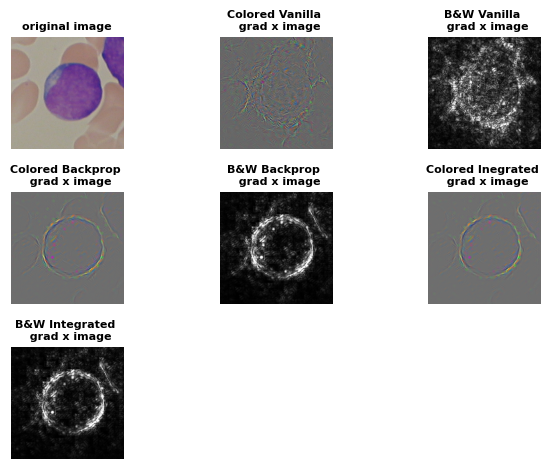

In [22]:

grad_times_image, grayscale_vanilla_grads, BackProg_times_image,grayscale_BackProg_grads, integrated_grads_times, grayscale_int_grads_times = Grad_times_process(img, pret_mod)

images = [img, grad_times_image, grayscale_vanilla_grads, BackProg_times_image,grayscale_BackProg_grads,
          integrated_grads_times, grayscale_int_grads_times ]
captions = ['original image', 'Colored Vanilla \n  grad x image',
            'B&W Vanilla \n  grad x image', 'Colored Backprop \n  grad x image', 'B&W Backprop \n  grad x image',
            'Colored Inegrated \n  grad x image', 'B&W Integrated \n  grad x image']
fig = download_images(images, captions, cols = 3, rows = 3, size = 8)

# Guided Grad-Cam

In [23]:
def get_positive_negative_saliency(gradient):
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency

def apply_colormap_on_image(org_im, activation, colormap_name):
    color_map = cm.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)

    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    shapes = (np.array(org_im).shape[1], np.array(org_im).shape[0])
    heatmap_on_image = heatmap.resize(shapes, Image.ANTIALIAS)
    heatmap_on_image =  Image.blend(org_im.convert("RGBA"), heatmap_on_image, 0.5)
    return no_trans_heatmap, heatmap_on_image

def save_class_activation_images(org_img, activation_map):
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    activation_map = save_image(activation_map )
    return heatmap, heatmap_on_image, activation_map

class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        def relu_backward_hook_function(module, grad_in, grad_out):
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            self.forward_relu_outputs.append(ten_out)
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr


def guided_grad_cam(grad_cam_mask, guided_backprop_mask):
    cam_gb = np.multiply(grad_cam_mask, guided_backprop_mask)
    return cam_gb

class CamExtractor():

    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.model.classifier(x)
        return conv_output, x


class GradCam():
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        target = conv_output.data.numpy()[0]
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
        return cam


def gradient_gradcam(model, img):
  gcv2 = GradCam(model, target_layer=11)
  im, pred_cls = process_img(img, model)
  cam = gcv2.generate_cam(im, pred_cls)
  GBP = GuidedBackprop(model)
  guided_grads = GBP.generate_gradients(im, pred_cls)
  cam_gb = guided_grad_cam(cam, guided_grads)
  cam_im =save_gradient_images(cam_gb)
  cam_gs = convert_to_grayscale(cam_gb)
  cam_gs =save_gradient_images(cam_gs)
  return cam_im, cam_gs


def download_images(images, captions, cols = 3, rows = 1, size =10):
    n_img = len(images)
    n_plot = cols * rows
    figure, axis = plt.subplots(rows, cols)
    ax = axis.flatten()
    for i in range(n_img):
      ax[i].imshow(images[i])
      ax[i].axis('off')
      if captions is not None:
        ax[i].set_title(str(captions[i]), fontweight="bold", size=size)
    if n_img < n_plot:
      ax[-1].set_visible(False)
    plt.tight_layout()

<ipython-input-23-adf00eeb5834>:124: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  input_image.shape[3]), Image.ANTIALIAS))/255


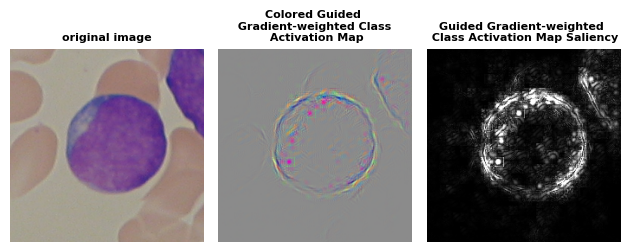

In [24]:
cam_im, cam_gs = gradient_gradcam(pret_mod, img)

images = [img, cam_im, cam_gs]
captions = ['original image', 'Colored Guided \n Gradient-weighted Class \n Activation Map',
            'Guided Gradient-weighted \n Class Activation Map Saliency']
fig = download_images(images, captions, cols = 3, rows = 1, size = 8)

# Guided propagation

In [25]:
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        def relu_backward_hook_function(module, grad_in, grad_out):
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            self.forward_relu_outputs.append(ten_out)
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr


def GuidedBackprop_process(model, img):
  GuideProg = GuidedBackprop(model)
  im, pred_cls = process_img(img, model)
  gradient = GuideProg.generate_gradients(im, pred_cls)
  grad_im =save_gradient_images(gradient)
  grad_bn= convert_to_grayscale(gradient)
  grad_im_bn =save_gradient_images(grad_bn)
  pos_sal, neg_sal = get_positive_negative_saliency(gradient)
  pos_sal =save_gradient_images(pos_sal)
  neg_sal =save_gradient_images(neg_sal)
  return grad_im, grad_im_bn, pos_sal, neg_sal

def download_images(images, captions, cols = 3, rows = 1, size =10):
    n_img = len(images)
    n_plot = cols * rows
    figure, axis = plt.subplots(rows, cols)
    ax = axis.flatten()
    for i in range(n_img):
      ax[i].imshow(images[i])
      ax[i].axis('off')
      if captions is not None:
        ax[i].set_title(str(captions[i]), fontweight="bold", size=size)
    if n_img < n_plot:
      ax[-1].set_visible(False)
    plt.tight_layout()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


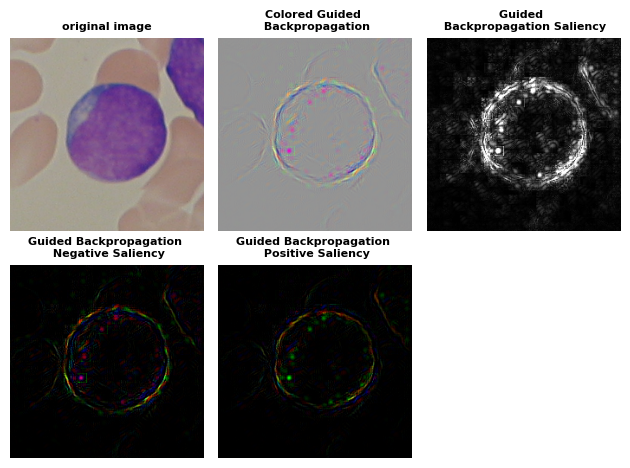

In [26]:
im, im1, pos_sal, neg_sal =GuidedBackprop_process(pret_mod, img)
images = [img, im, im1, pos_sal, neg_sal]
captions = ['original image', 'Colored Guided \n Backpropagation', 'Guided \n Backpropagation Saliency',
            'Guided Backpropagation \n Negative Saliency', 'Guided Backpropagation \n Positive Saliency']
fig = download_images(images, captions, cols = 3, rows = 2, size = 8)

# Integrated Gradient

In [27]:
class IntegratedGradients():
    """
        Produces gradients generated with integrated gradients from the image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.model.eval()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def generate_images_on_linear_path(self, input_image, steps):
        step_list = np.arange(steps+1)/steps
        xbar_list = [input_image*step for step in step_list]
        return xbar_list

    def generate_gradients(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

    def generate_integrated_gradients(self, input_image, target_class, steps):
        xbar_list = self.generate_images_on_linear_path(input_image, steps)
        integrated_grads = np.zeros(input_image.size())
        for xbar_image in xbar_list:
            single_integrated_grad = self.generate_gradients(xbar_image, target_class)
            integrated_grads = integrated_grads + single_integrated_grad/steps
        return integrated_grads[0]


def integrated_gradient_process(img, model):
    im, pred_cls = process_img(img, model)
    IG = IntegratedGradients(model)
    integrated_grads = IG.generate_integrated_gradients(im, pred_cls, 100)
    grayscale_integrated_grads = convert_to_grayscale(integrated_grads)
    im = save_gradient_images(integrated_grads)
    im_bn = save_gradient_images(grayscale_integrated_grads)
    return im, im_bn

def download_images(images, captions, cols = 3, rows = 1, size =10):
    n_img = len(images)
    n_plot = cols * rows
    figure, axis = plt.subplots(rows, cols)
    ax = axis.flatten()
    for i in range(n_img):
      ax[i].imshow(images[i])
      ax[i].axis('off')
      if captions is not None:
        ax[i].set_title(str(captions[i]), fontweight="bold", size=size)
    if n_img < n_plot:
      ax[-1].set_visible(False)
    plt.tight_layout()

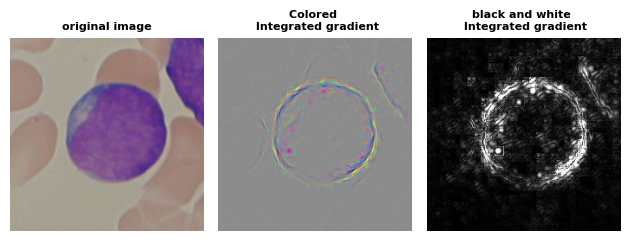

In [28]:
im, im_bn = integrated_gradient_process(img, pret_mod)

images = [img, im, im_bn]
captions = ['original image', 'Colored \n Integrated gradient',
            'black and white \n Integrated gradient']
fig = download_images(images, captions, cols = 3, rows = 1, size = 8)

In [29]:
def recreate_image(im_as_var):
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


from torch.optim import SGD
class InvertedRepresentation():
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def alpha_norm(self, input_matrix, alpha):
        alpha_norm = ((input_matrix.view(-1))**alpha).sum()
        return alpha_norm

    def total_variation_norm(self, input_matrix, beta):
        to_check = input_matrix[:, :-1, :-1]  # Trimmed: right - bottom
        one_bottom = input_matrix[:, 1:, :-1]  # Trimmed: top - right
        one_right = input_matrix[:, :-1, 1:]  # Trimmed: top - right
        total_variation = (((to_check - one_bottom)**2 +
                            (to_check - one_right)**2)**(beta/2)).sum()
        return total_variation

    def euclidian_loss(self, org_matrix, target_matrix):
        distance_matrix = target_matrix - org_matrix
        euclidian_distance = self.alpha_norm(distance_matrix, 2)
        normalized_euclidian_distance = euclidian_distance / self.alpha_norm(org_matrix, 2)
        return normalized_euclidian_distance

    def get_output_from_specific_layer(self, x, layer_id):
        layer_output = None
        for index, layer in enumerate(self.model.features):
            x = layer(x)
            if str(index) == str(layer_id):
                layer_output = x[0]
                break
        return layer_output

    def generate_inverted_image_specific_layer(self, input_image, img_size, target_layer=3):
        opt_img = Variable(1e-1 * torch.randn(1, 3, img_size, img_size), requires_grad=True)
        optimizer = SGD([opt_img], lr=1e4, momentum=0.9)
        input_image_layer_output = \
            self.get_output_from_specific_layer(input_image, target_layer)
        alpha_reg_alpha = 6
        alpha_reg_lambda = 1e-7
        tv_reg_beta = 2
        tv_reg_lambda = 1e-8
        images = list()

        for i in range(201):
            optimizer.zero_grad()
            output = self.get_output_from_specific_layer(opt_img, target_layer)
            euc_loss = 1e-1 * self.euclidian_loss(input_image_layer_output.detach(), output)
            reg_alpha = alpha_reg_lambda * self.alpha_norm(opt_img, alpha_reg_alpha)
            reg_total_variation = tv_reg_lambda * self.total_variation_norm(opt_img,
                                                                            tv_reg_beta)
            loss = euc_loss + reg_alpha + reg_total_variation
            loss.backward()
            optimizer.step()
            # Generate image every 25 iterations
            if i % 25 == 0:
                print('Iteration:', str(i), 'Loss:', loss.data.numpy())
                recreated_im = recreate_image(opt_img)
                im =save_image(recreated_im)
                images.append(im)

            if i % 40 == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 1/10
        return images

# Inverted representation

Iteration: 0 Loss: 0.023760457
Iteration: 25 Loss: 0.01111528
Iteration: 50 Loss: 0.008584379
Iteration: 75 Loss: 0.008298312
Iteration: 100 Loss: 0.008213204
Iteration: 125 Loss: 0.008190668
Iteration: 150 Loss: 0.008188046
Iteration: 175 Loss: 0.008186746
Iteration: 200 Loss: 0.008186484


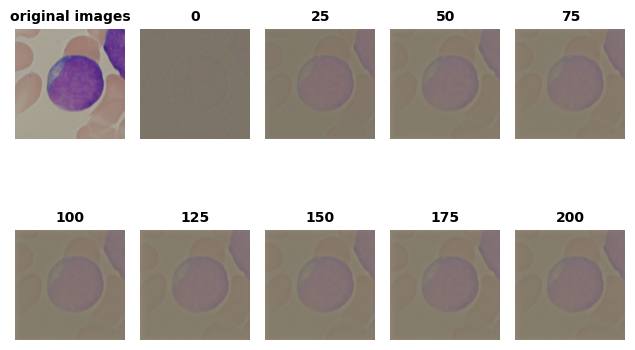

In [30]:
def inverted_representation_process(img, model, image_size,target_layer):
  '''
  inverted representation
  '''
  im, pred_cls = process_img(img, model)
  inverted_representation = InvertedRepresentation(model)
  images = inverted_representation.generate_inverted_image_specific_layer(im, image_size,target_layer)
  return images

def download_images(images, captions, cols = 3, rows = 1, size =10):
    n_img = len(images)
    n_plot = cols * rows
    figure, axis = plt.subplots(rows, cols)
    ax = axis.flatten()
    for i in range(n_img):
      ax[i].imshow(images[i])
      ax[i].axis('off')
      if captions is not None:
        ax[i].set_title(str(captions[i]), fontweight="bold", size=size)
    if n_img < n_plot:
      ax[-1].set_visible(False)
    plt.tight_layout()


target_layer = 0
image_size = 224

images = inverted_representation_process(img, pret_mod, image_size,target_layer)

images = [img] +images
captions = ['original images'] + [str(i) for i in range(0,201,25)]
download_images(images, captions, cols = 5, rows = 2, size =10)

# LayerCAM

In [32]:
class CamExtractor():

    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):

        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.model.classifier(x)
        return conv_output, x


class LayerCam():

    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        target = conv_output.data.numpy()[0]
        weights = guided_gradients
        weights[weights < 0] = 0 # discard negative gradients
        cam = np.sum(weights * target, axis=0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255

        return cam


def LayerCAM_process(img, model, layer =1):
  im, pred_cls = process_img(img, model)
  layer_cam = LayerCam(model, target_layer=layer)
  cam = layer_cam.generate_cam(im, pred_cls)
  heatmap, heatmap_on_image, activation_map = save_class_activation_images(img, cam)
  return heatmap, heatmap_on_image, activation_map


def download_images(images, captions, cols = 3, rows = 1, size =10):
    n_img = len(images)
    n_plot = cols * rows
    figure, axis = plt.subplots(rows, cols)
    ax = axis.flatten()
    for i in range(n_img):
      ax[i].imshow(images[i])
      ax[i].axis('off')
      if captions is not None:
        ax[i].set_title(str(captions[i]), fontweight="bold", size=size)
    if n_img < n_plot:
      ax[-1].set_visible(False)
    plt.tight_layout()

<ipython-input-32-3b4e3a4b7585>:53: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  input_image.shape[3]), Image.ANTIALIAS))/255
<ipython-input-23-adf00eeb5834>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap(colormap_name)
<ipython-input-23-adf00eeb5834>:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  heatmap_on_image = heatmap.resize(shapes, Image.ANTIALIAS)


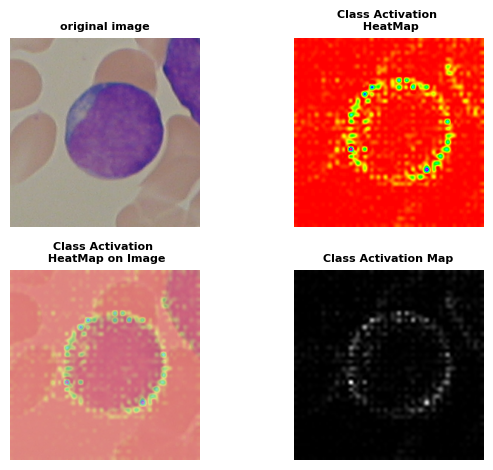

In [33]:
heatmap, heatmap_on_image, activation_map = LayerCAM_process(img, pret_mod, layer =1)

images = [img, heatmap, heatmap_on_image, activation_map]
captions = ['original image', 'Class Activation \n HeatMap', 'Class Activation \n HeatMap on Image', 'Class Activation Map']
fig = download_images(images, captions, cols = 2, rows = 2, size = 8)

# Layer activation with guided backpropagation

In [34]:
class GuidedBackprop():
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        def relu_backward_hook_function(module, grad_in, grad_out):
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            self.forward_relu_outputs.append(ten_out)

        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class, cnn_layer, filter_pos):
        self.model.zero_grad()
        x = input_image
        for index, layer in enumerate(self.model.features):
            x = layer(x)
            if index == cnn_layer:
                break
        conv_output = torch.sum(torch.abs(x[0, filter_pos]))
        conv_output.backward()
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr


cnn_layer = 6
filter_pos = 14
def layer_act_guid_bp(img, model, cnn_layer, filter_pos):
  im, pred_cls = process_img(img, model)
  GBP = GuidedBackprop(model)
  guided_grads = GBP.generate_gradients(im, pred_cls, cnn_layer, filter_pos)
  col_grad_img =save_gradient_images(guided_grads)
  grayscale_guided_grads = convert_to_grayscale(guided_grads)
  grayscale_guided_grads =save_gradient_images(grayscale_guided_grads)
  pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
  pos_sal =save_gradient_images(pos_sal)
  neg_sal =save_gradient_images(neg_sal)
  return [col_grad_img, grayscale_guided_grads, pos_sal, neg_sal]


def download_images(images, captions, cols = 3, rows = 1, size =10):
    n_img = len(images)
    n_plot = cols * rows
    figure, axis = plt.subplots(rows, cols)
    ax = axis.flatten()
    for i in range(n_img):
      ax[i].imshow(images[i])
      ax[i].axis('off')
      if captions is not None:
        ax[i].set_title(str(captions[i]), fontweight="bold", size=size)
    if n_img < n_plot:
      ax[-1].set_visible(False)
    plt.tight_layout()

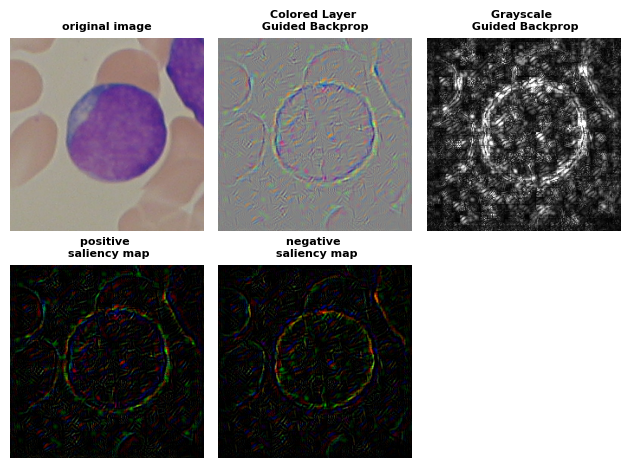

In [35]:
images= layer_act_guid_bp(img, pret_mod, cnn_layer, filter_pos)
imgs = [img]
imgs = imgs + images
captions = ['original image', 'Colored Layer \n Guided Backprop ',
            'Grayscale \n Guided Backprop', 'positive \n saliency map',
            'negative \n saliency map']
fig = download_images(imgs, captions, cols = 3, rows = 2, size = 8)

# Layerwise Relevance

In [42]:
from matplotlib.colors import ListedColormap
from PIL import Image
import requests
from io import BytesIO
from copy import deepcopy
def apply_heatmap(R, sx, sy):
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:, 0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    plt.figure(figsize=(sx, sy))
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.axis('off')
    plt.imshow(R, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    with BytesIO() as buffer:
      plt.savefig(buffer, format = "png")
      buffer.seek(0)
      image = Image.open(buffer)
      ar = np.asarray(image)
    return image




class LRP():
    def __init__(self, model):
        self.model = model

    def LRP_forward(self, layer, input_tensor, gamma=None, epsilon=None):

        if gamma is None:
            gamma = lambda value: value + 0.05 * copy.deepcopy(value.data.detach()).clamp(min=0)
        if epsilon is None:
            eps = 1e-9
            epsilon = lambda value: value + eps
        layer = copy.deepcopy(layer)

        try:
            layer.weight = nn.Parameter(gamma(layer.weight))
        except AttributeError:
            pass

        try:
            layer.bias = nn.Parameter(gamma(layer.bias))
        except AttributeError:
            pass


        return epsilon(layer(input_tensor))

    def LRP_step(self, forward_output, layer, LRP_next_layer):

        forward_output = forward_output.requires_grad_(True)

        lrp_rule_forward_out = self.LRP_forward(layer, forward_output, None, None)

        ele_div = (LRP_next_layer / lrp_rule_forward_out).data

        (lrp_rule_forward_out * ele_div).sum().backward()

        LRP_this_layer = (forward_output * forward_output.grad).data

        return LRP_this_layer

    def generate(self, input_image, target_class):
        layers_in_model = list(self.model._modules['features']) + list(self.model._modules['classifier'])
        number_of_layers = len(layers_in_model)

        features_to_classifier_loc = len(self.model._modules['features'])

        forward_output = [input_image]

        for conv_layer in list(self.model._modules['features']):
            forward_output.append(conv_layer.forward(forward_output[-1].detach()))

        feature_to_class_shape = forward_output[-1].shape

        forward_output[-1] = torch.flatten(forward_output[-1], 1)
        for index, classifier_layer in enumerate(list(self.model._modules['classifier'])):
            forward_output.append(classifier_layer.forward(forward_output[-1].detach()))

        target_class_one_hot = torch.FloatTensor(1, 2).zero_()
        target_class_one_hot[0][target_class] = 1

        LRP_per_layer = [None] * number_of_layers + [(forward_output[-1] * target_class_one_hot).data]

        for layer_index in range(1, number_of_layers)[::-1]:

            if layer_index == features_to_classifier_loc-1:
                LRP_per_layer[layer_index+1] = LRP_per_layer[layer_index+1].reshape(feature_to_class_shape)

            if isinstance(layers_in_model[layer_index], (torch.nn.Linear, torch.nn.Conv2d, torch.nn.MaxPool2d)):

                lrp_this_layer = self.LRP_step(forward_output[layer_index], layers_in_model[layer_index], LRP_per_layer[layer_index+1])
                LRP_per_layer[layer_index] = lrp_this_layer
            else:
                LRP_per_layer[layer_index] = LRP_per_layer[layer_index+1]
        return LRP_per_layer

<ipython-input-44-f9ae1b65372f>:34: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im.shape[3]), Image.ANTIALIAS))


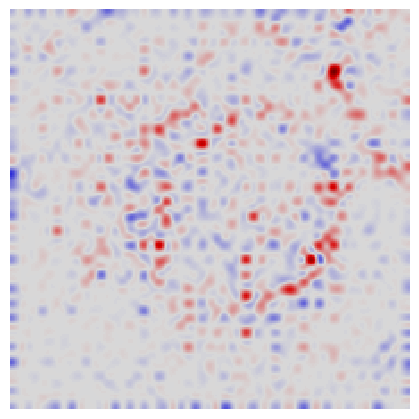

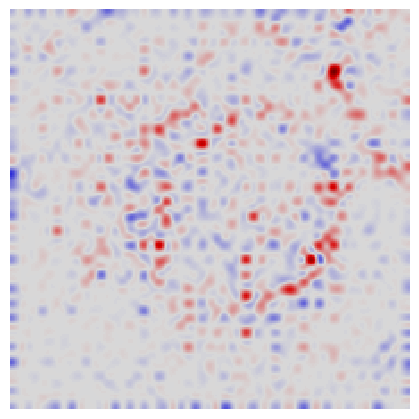

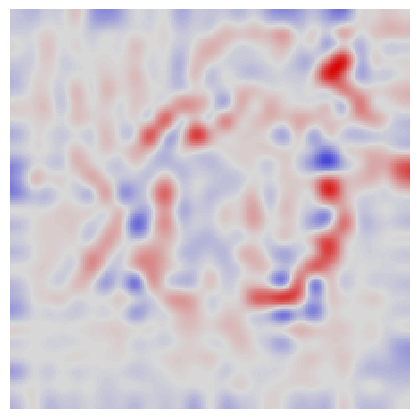

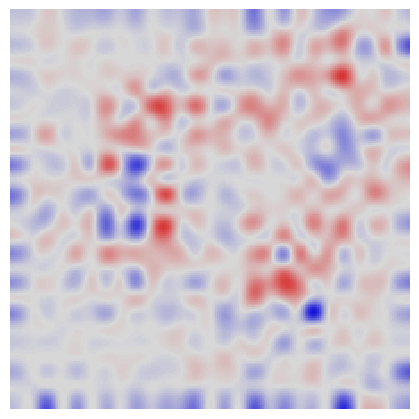

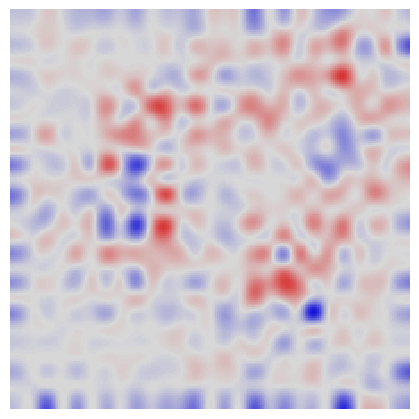

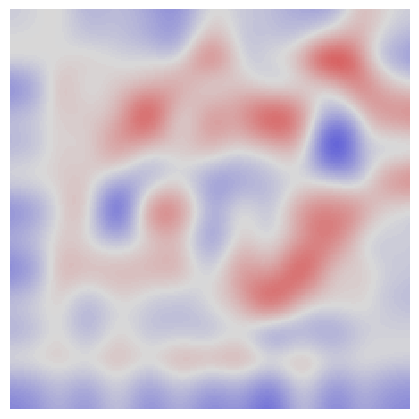

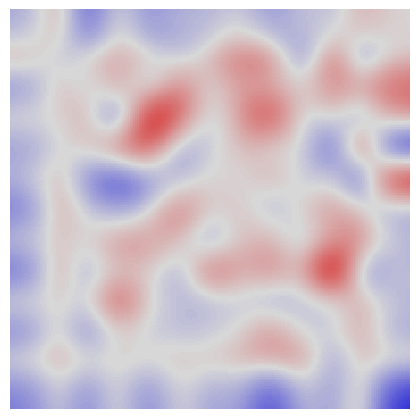

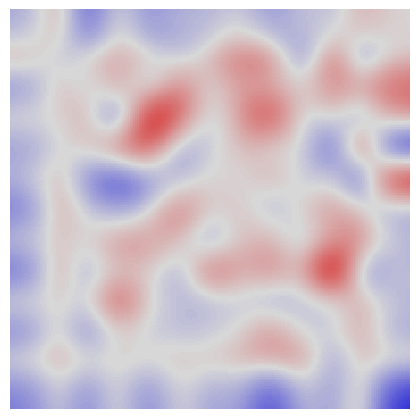

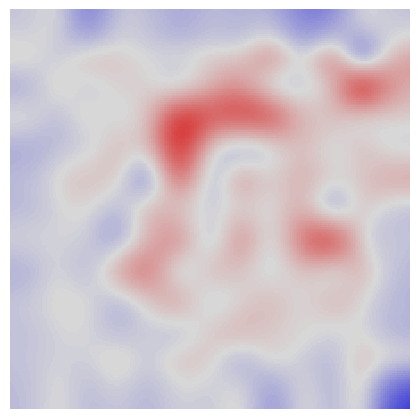

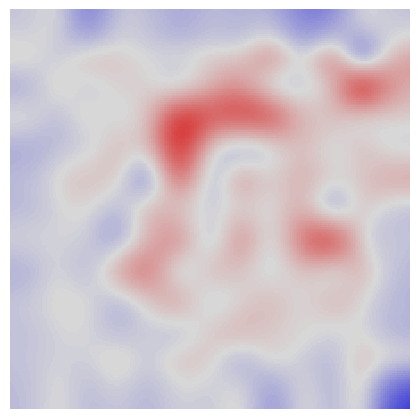

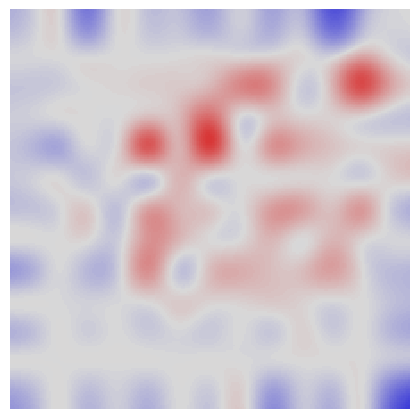

In [44]:
def LRP_process(model, img, layer = 1):
  layerwise_relevance = LRP(model)
  im, pred_cls = process_img(img, model)
  LRP_per_layer = layerwise_relevance.generate(im, pred_cls)
  lrp_to_vis = np.array(LRP_per_layer[layer][0]).sum(axis=0)
  lrp_to_vis = np.array(Image.fromarray(lrp_to_vis).resize((im.shape[2],
                          im.shape[3]), Image.ANTIALIAS))
  heatmap = apply_heatmap(lrp_to_vis, 4, 4)
  return heatmap

def download_images(images, captions, cols = 3, rows = 1, size =10):
    n_img = len(images)
    n_plot = cols * rows
    figure, axis = plt.subplots(rows, cols)
    ax = axis.flatten()
    for i in range(n_img):
      ax[i].imshow(images[i])
      ax[i].axis('off')
      if captions is not None:
        ax[i].set_title(str(captions[i]), fontweight="bold", size=size)
    if n_img < n_plot:
      ax[-1].set_visible(False)
    plt.tight_layout()


def LRP_process_all_layers(model, img, n_layers=10):
  layerwise_relevance = LRP(model)
  im, pred_cls = process_img(img, model)
  LRP_per_layer = layerwise_relevance.generate(im, pred_cls)
  heat_list = list()
  for layer in range(1,n_layers):
      lrp_to_vis = np.array(LRP_per_layer[layer][0]).sum(axis=0)
      lrp_to_vis = np.array(Image.fromarray(lrp_to_vis).resize((im.shape[2],
                              im.shape[3]), Image.ANTIALIAS))
      heatmap = apply_heatmap(lrp_to_vis, 4, 4)
      heat_list.append(heatmap)
  return heat_list
heat_list =LRP_process_all_layers(pret_mod, img, n_layers=12)

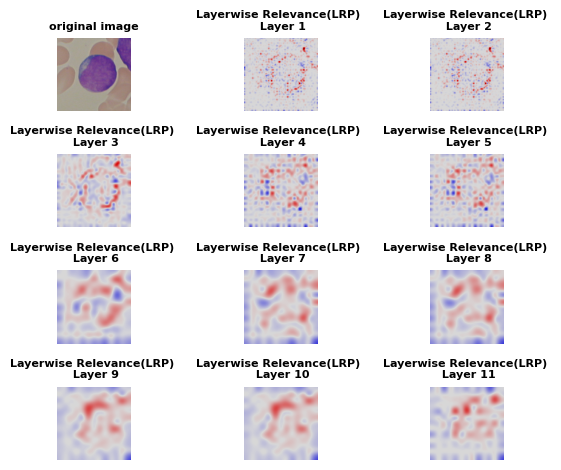

In [45]:
caps = ['Layerwise Relevance(LRP) \n Layer ' +str(i) for i in range(1,12)]
captions =['original image']
captions = captions + caps
images = [img]
images = images + heat_list
fig = download_images(images, captions, cols = 3, rows = 4, size = 8)


<ipython-input-44-f9ae1b65372f>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im.shape[3]), Image.ANTIALIAS))


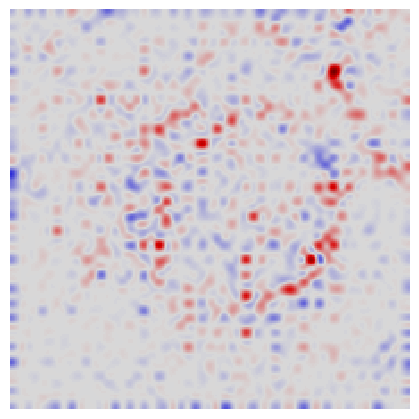

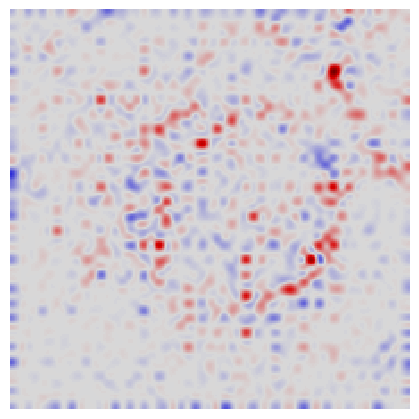

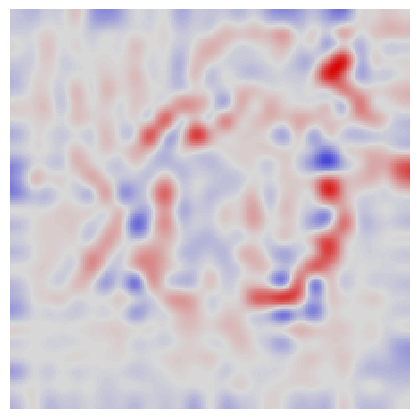

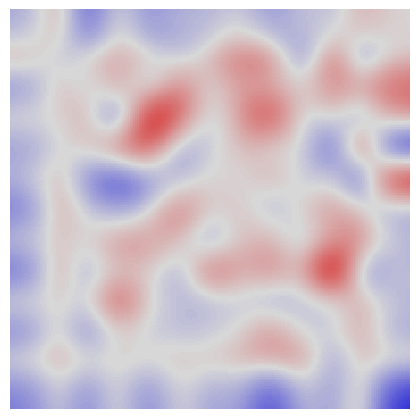

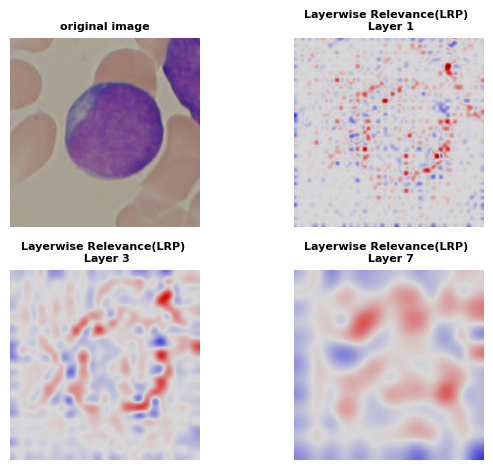

In [47]:
heatmap_1 =LRP_process(pret_mod, img,  layer = 1)
heatmaps = []

for l in [1,3,7]:
  heatmap_1 =LRP_process(pret_mod, img,  layer = l)
  heatmaps.append(heatmap_1)

caps = ['Layerwise Relevance(LRP) \n Layer ' +str(i) for i in [1,3,7]]
captions =['original image']
captions = captions + caps
images = [img]
images = images + heatmaps
fig = download_images(images, captions, cols =2, rows = 2, size = 8)

# ScoreCam

In [48]:
def scorecam_process(model, img):
  im, pred_cls = process_img(img, model)
  score_cam = ScoreCam(model, target_layer=11)
  cam = score_cam.generate_cam(im, pred_cls)
  return cam


class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

    def forward_pass_on_convolutions(self, x):
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.model.classifier(x)
        return conv_output, x


class ScoreCam():
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        target = conv_output[0]
        cam = np.ones(target.shape[1:], dtype=np.float32)
        for i in range(len(target)):
            saliency_map = torch.unsqueeze(torch.unsqueeze(target[i, :, :],0),0)
            saliency_map = F.interpolate(saliency_map, size=(224, 224), mode='bilinear', align_corners=False)
            if saliency_map.max() == saliency_map.min():
                continue
            norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
            w = F.softmax(self.extractor.forward_pass(input_image*norm_saliency_map)[1],dim=1)[0][target_class]
            cam += w.data.numpy() * target[i, :, :].data.numpy()
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
        return cam

<ipython-input-48-027e8fdfc70b>:56: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  input_image.shape[3]), Image.ANTIALIAS))/255
<ipython-input-23-adf00eeb5834>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap(colormap_name)
<ipython-input-23-adf00eeb5834>:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  heatmap_on_image = heatmap.resize(shapes, Image.ANTIALIAS)


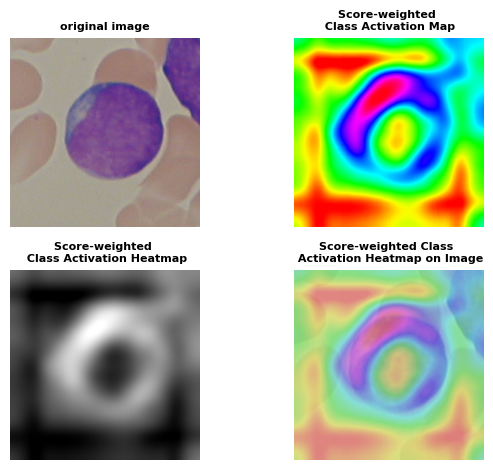

In [52]:
import torch.nn.functional as F
def scorecam_process(model, img, target_layer=11):
  im, pred_cls = process_img(img, model)
  score_cam = ScoreCam(model, target_layer=target_layer)
  cam = score_cam.generate_cam(im, pred_cls)
  return cam

def download_images(images, captions, cols = 3, rows = 1, size =10):
    n_img = len(images)
    n_plot = cols * rows
    figure, axis = plt.subplots(rows, cols)
    ax = axis.flatten()
    for i in range(n_img):
      ax[i].imshow(images[i])
      ax[i].axis('off')
      if captions is not None:
        ax[i].set_title(str(captions[i]), fontweight="bold", size=size)
    if n_img < n_plot:
      ax[-1].set_visible(False)
    plt.tight_layout()


scorecam = scorecam_process(pret_mod, img, target_layer=11)
heatmap, heatmap_on_image, activation_map = save_class_activation_images(img, scorecam)
images = [img, heatmap, activation_map, heatmap_on_image]
captions = ['original image', 'Score-weighted \n Class Activation Map', 'Score-weighted \n Class Activation Heatmap',
            'Score-weighted Class \n Activation Heatmap on Image']
fig = download_images(images, captions, cols = 2, rows = 2, size = 8)

# Smooth Grad

In [53]:
class VanillaBackprop():
    """
        Produces gradients generated with vanilla back propagation from the image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None

        self.model.eval()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def generate_gradients(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

def generate_smooth_grad(Backprop, prep_img, target_class, param_n, param_sigma_multiplier):

    smooth_grad = np.zeros(prep_img.size()[1:])

    mean = 0
    sigma = param_sigma_multiplier / (torch.max(prep_img) - torch.min(prep_img)).item()
    for x in range(param_n):

        noise = Variable(prep_img.data.new(prep_img.size()).normal_(mean, sigma**2))
        noisy_img = prep_img + noise
        vanilla_grads = Backprop.generate_gradients(noisy_img, target_class)
        smooth_grad = smooth_grad + vanilla_grads
    smooth_grad = smooth_grad / param_n
    return smooth_grad



def smooth_grad_process(img, model):
  im, pred_cls = process_img(img, model)
  param_n = 50
  VBP = VanillaBackprop(model)
  smooths = list()
  smooths_bn = list()
  for param_sigma in range(1,6):

    smooth_grad = generate_smooth_grad(VBP, im, pred_cls, param_n, param_sigma)
    smooth_grad_bn = convert_to_grayscale(smooth_grad)
    smooth_grad = save_gradient_images(smooth_grad)
    smooth_grad_bn = save_gradient_images(smooth_grad_bn)
    smooths.append(smooth_grad)
    smooths_bn.append(smooth_grad_bn)
  return smooths, smooths_bn

def download_images(images, captions, cols = 3, rows = 1, size =10):
    n_img = len(images)
    n_plot = cols * rows
    figure, axis = plt.subplots(rows, cols)
    ax = axis.flatten()
    for i in range(n_img):
      ax[i].imshow(images[i])
      ax[i].axis('off')
      if captions is not None:
        ax[i].set_title(str(captions[i]), fontweight="bold", size=size)
    if n_img < n_plot:
      ax[-1].set_visible(False)
    plt.tight_layout()

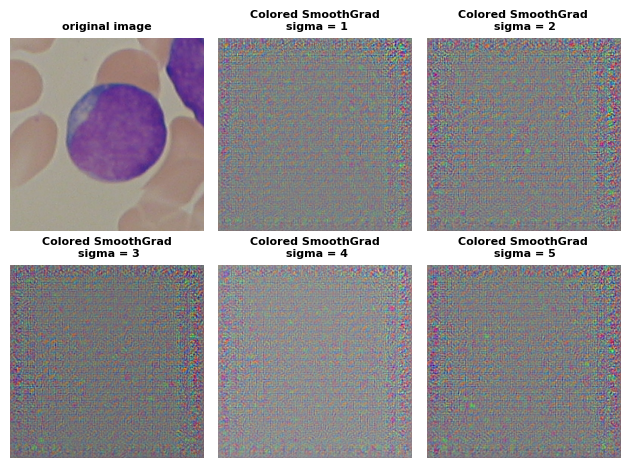

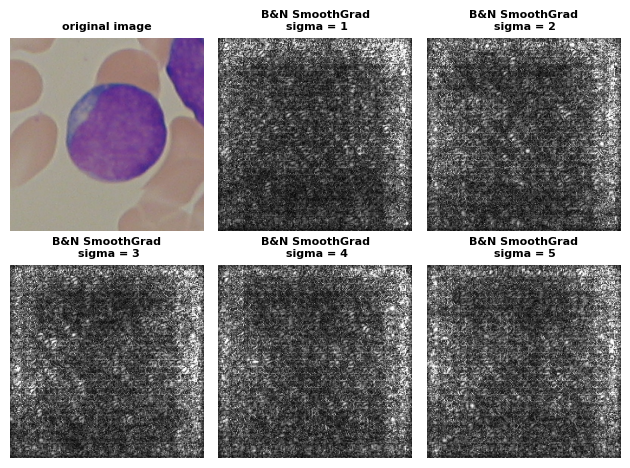

In [55]:
#plotting different sigma
smooths, smooths_bn = smooth_grad_process(img, pret_mod)
len(smooths), len(smooths_bn)
captions = ['original image', 'Colored SmoothGrad\n sigma = 1', 'Colored SmoothGrad\n sigma = 2',
            'Colored SmoothGrad\n sigma = 3', 'Colored SmoothGrad\n sigma = 4', 'Colored SmoothGrad\n sigma = 5']
imgs = [img]
imgs = imgs + smooths
fig = download_images(imgs, captions, cols = 3, rows = 2, size = 8)
captions = ['original image', 'B&N SmoothGrad\n sigma = 1', 'B&N SmoothGrad\n sigma = 2',
            'B&N SmoothGrad\n sigma = 3', 'B&N SmoothGrad\n sigma = 4', 'B&N SmoothGrad\n sigma = 5']
imgs = [img]
imgs = imgs + smooths_bn
fig = download_images(imgs, captions, cols = 3, rows = 2, size = 8)

# Vanilla propagation

In [57]:
class VanillaBackprop():
    """
        Produces gradients generated with vanilla back propagation from the image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None

        self.model.eval()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def generate_gradients(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

def VanillaBackprop_process(model, img):
  VBP = VanillaBackprop(model)
  im, pred_cls = process_img(img, model)
  gradient = VBP.generate_gradients(im, pred_cls)
  grad_im =save_gradient_images(gradient)
  grad_bn= convert_to_grayscale(gradient)
  grad_im_bn =save_gradient_images(grad_bn)
  return grad_im, grad_im_bn

def download_images(images, captions, cols = 3, rows = 1):
    n_img = len(images)
    figure, axis = plt.subplots(rows, cols)
    ax = axis.flatten()
    for i in range(n_img):
      ax[i].imshow(images[i])
      ax[i].axis('off')
      if captions is not None:
        ax[i].set_title(str(captions[i]))
    plt.tight_layout()

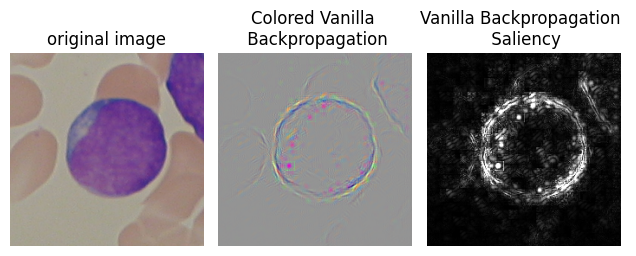

In [58]:
im, im1 =VanillaBackprop_process(pret_mod, img)
images = [img,im, im1]
captions = ['original image', 'Colored Vanilla \n Backpropagation', 'Vanilla Backpropagation \n Saliency']
fig = download_images(images, captions, cols = 3, rows = 1)
